In [1]:
from pyomo.environ import *
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
size_font = 10

In [2]:
P_load = pd.read_excel('load_data.xlsx', sheet_name='Yearly Load', header=0)
time = range(len(P_load))

P_load_dict = dict()
for i in range(len(P_load)):
    P_load_dict[i] = P_load['Load [MW]'].values[i]


In [3]:
P_ren = pd.read_csv('RESData_option-2.csv', header=0, nrows = 8760)
P_ren['Power'] = P_ren['Power']/1e6*10 #MW

P_ren_dict = dict()
for i in range(len(P_ren)):
    P_ren_dict[i] = P_ren['Power'].values[i] #MW


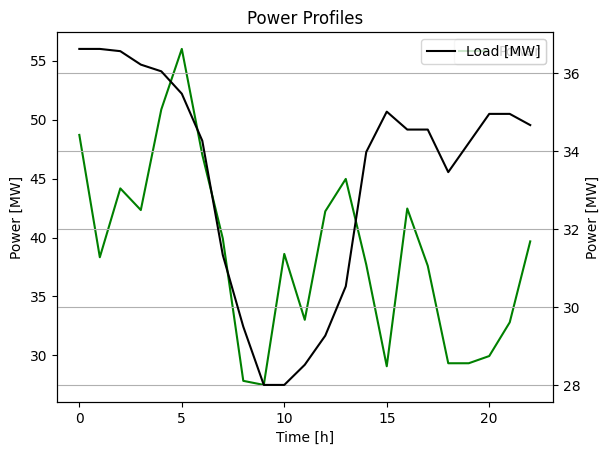

In [45]:
ax_gen = plt.gca()

P_ren.iloc[0:23].plot(kind='line',y='Power',ax=ax_gen, color='green')
ax_gen.set_ylabel("Power [MW]")
ax_gen.set_xlabel("Time [h]")
ax_gen.set_title('Power Profiles')

ax_load = plt.twinx(ax_gen)

P_load.iloc[0:23].plot(kind='line',y='Load [MW]',ax=ax_load, color='black')
ax_load.set_ylabel("Power [MW]")
ax_load.set_xlabel("Time [h]")



#ax.tick_params(axis='both', which='major', labelsize=size_font)
plt.grid(True)
#plt.savefig('load_profile.png',bbox_inches='tight', dpi=150)
plt.show()

In [46]:
model = ConcreteModel()
model.hIDX = Set(initialize = range(len(P_ren_dict))) 
model.P_load = Param(model.hIDX, initialize = P_load_dict) #kW
model.P_ren = Param(model.hIDX, initialize = P_ren_dict) #kW
model.eff_ch = Param(initialize=sqrt(0.95)) #square root of roundtrip efficiency used in amazing reference
model.eff_dch = Param(initialize=sqrt(0.95))
model.C_P = Param(initialize=320) #$/kW
model.C_E = Param(initialize=360) #$/kWh
model.C_inst = Param(initialize=15) #$/kWh
model.C_OM = Param(initialize=5) #$/kW
model.IR = Param(initialize=0.05)
model.sigma = Param(initialize=0.002/24) #original daily self discharge is 0,2% -> we need an hourly self discharge
model.life = Param(initialize=15)
model.gamma_min = Param(initialize=0)
model.gamma_MAX = Param(initialize=13)
model.price_g = Param(initialize = 0.01) #$/kWh

model.Pr_BES = Var(domain=NonNegativeReals)
model.Er_BES = Var(domain=NonNegativeReals)
model.P_grid = Var(model.hIDX, domain=Reals)
model.P_BES = Var(model.hIDX, domain=Reals)
model.P_ch = Var(model.hIDX, domain=NonNegativeReals)
model.P_dch = Var(model.hIDX, domain=NonNegativeReals)
model.SOC = Var(model.hIDX, domain=NonNegativeReals)
model.SOC_ini = Var(domain=NonNegativeReals)
model.chi_dch = Var(model.hIDX,domain=Binary)


In [47]:
def obj_expression(model):
  return sum((model.P_BES[h]) for h in model.hIDX) #model.Pr_BES*model.C_P*1e3 + model.Er_BES*(model.C_E+model.C_inst)*1e3 + sum(model.P_grid[h] for h in model.hIDX)*model.price_g*1e3

model.obj = Objective(rule=obj_expression, sense=minimize)

def equilibrium_constraint(model,h):
    return model.P_BES[h] + model.P_ren[h] + model.P_grid[h] == model.P_load[h]

model.eq_cstr = Constraint(model.hIDX, rule=equilibrium_constraint)

# def power_BES_constraint(model,h):
#     return model.P_BES[h] == model.P_dch[h] - model.P_ch[h]

# model.P_BES_str = Constraint(model.hIDX, rule=power_BES_constraint)

def SOC_ini_constraint(model):
    return model.SOC_ini <= model.Er_BES

model.SOC_ini_cstr = Constraint(rule=SOC_ini_constraint)

def SOC_bounds_constraint(model,h):
    return model.SOC[h] <= model.Er_BES

model.SOC_bounds_cstr = Constraint(model.hIDX, rule=SOC_bounds_constraint)

def SOC_constraint(model,h):
    if h==0:
        return model.SOC[h] == model.SOC_ini
    else:
        return model.SOC[h] == model.SOC[h-1]*(1-model.sigma) + model.P_BES[h] # - model.P_dch[h]/model.eff_dch + model.P_ch[h]*model.eff_ch

model.SOC_cstr = Constraint(model.hIDX, rule=SOC_constraint)


# def capacity_constraint_lower(model):
#     return model.Er_BES>=model.gamma_min*model.Pr_BES 

# model.gamma_low_cstr = Constraint(rule=capacity_constraint_lower)

# def capacity_constraint_upper(model):
#     return model.Er_BES<=model.gamma_MAX*model.Pr_BES 

# model.gamma_up_cstr = Constraint(rule=capacity_constraint_upper)

# def discharge_constraint_1 (model,h):
#     return model.P_dch[h] <= model.Pr_BES

# model.dch_cstr_1 = Constraint(model.hIDX, rule=discharge_constraint_1)

# def discharge_constraint_2 (model,h):
#     return model.P_dch[h] <= model.chi_dch[h]*1e40

# model.dch_cstr_2 = Constraint(model.hIDX, rule=discharge_constraint_2)

# def charge_constraint_1 (model,h):
#     return model.P_ch[h] <= model.Pr_BES

# model.ch_cstr_1 = Constraint(model.hIDX, rule=charge_constraint_1)

# def charge_constraint_2 (model,h):
#     return model.P_dch[h] <= (1-model.chi_dch[h])*1e40

# model.ch_cstr_2 = Constraint(model.hIDX, rule=charge_constraint_2)

In [48]:
solver = SolverFactory("cbc.exe")
result = solver.solve(model)

    model.name="unknown";
      - termination condition: unbounded
      - message from solver: CBC 2.10.5 unbounded, objective
        -9999999998.32823; 14912 iterations


In [49]:
SOC = np.array([value(model.SOC[h]) for h in model.hIDX])
SOC = SOC/value(model.Er_BES)
P_BES = np.array([value(model.P_BES[h]) for h in model.hIDX])
P_load = np.array([value(model.P_load[h]) for h in model.hIDX])
P_grid = np.array([value(model.P_grid[h]) for h in model.hIDX])
P_ren = np.array([value(model.P_ren[h]) for h in model.hIDX])
Pr_BES = value(model.Pr_BES)
Er_BES = value(model.Er_BES)

print('The optimal storage capacity is ',Er_BES,' MWh, with a power of ', Pr_BES,'MW.\n')

ERROR: evaluating object as numeric value: SOC[0]
        (object: <class 'pyomo.core.base.var._GeneralVarData'>)
    No value for uninitialized NumericValue object SOC[0]


ValueError: No value for uninitialized NumericValue object SOC[0]

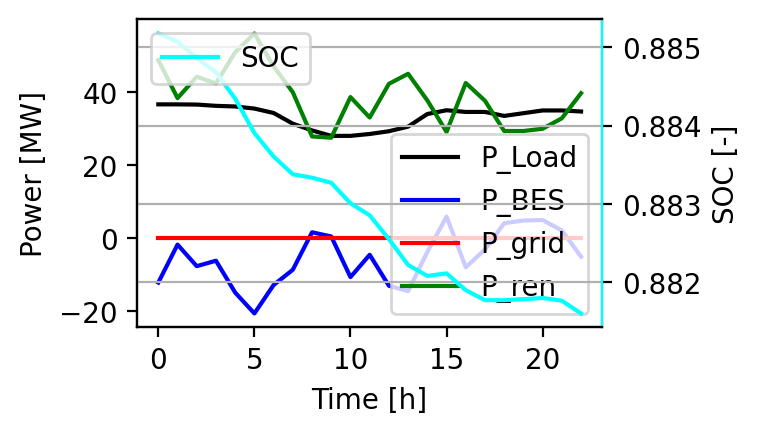

In [ ]:
fig, ax_pow = plt.subplots(figsize=(10,8))

ax_pow.set_ylabel("Power [MW]",fontsize=size_font)
ax_pow.set_xlabel("Time [h]",fontsize=size_font)
ax_pow.plot(time[0:23], P_load[0:23], color='black')
ax_pow.plot(time[0:23], P_BES[0:23], color = 'blue')
ax_pow.plot(time[0:23], P_grid[0:23], color = 'red')
ax_pow.plot(time[0:23], P_ren[0:23], color = 'green')
ax_pow.legend(['P_Load', 'P_BES', 'P_grid', 'P_ren'],loc=4)

ax_SOC = ax_pow.twinx()  # instantiate a second axes that shares the same x-axis

ax_SOC.set_ylabel('SOC [-]',fontsize=size_font)  # we already handled the x-label with ax1
ax_SOC.plot(time[0:23], SOC[0:23], color='cyan')
ax_SOC.legend(['SOC'],loc=2)

# ax_pow.spines['right'].set_position(('axes',0.15))

ax_pow.spines['right'].set_color("black")
ax_SOC.spines['right'].set_color("cyan")

plt.grid(True)


fig.set_size_inches(3,2)
fig.set_dpi(200)
ax_pow.tick_params(axis='both', which='major', labelsize=size_font)
ax_SOC.tick_params(axis='both', which='major', labelsize=size_font)

plt.savefig('powers_SOC.png',bbox_inches='tight', dpi=150)

plt.show()
plt.close()
